In [1]:
################################################
# This python script is designed to take the flight data from
# the sqlite3 database or .csv created in flight-price-api.py and create a model to predict the price
# of flights for any given day, airline and route.

# Thanks!
# Jeremy Beard
################################################

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import ConfusionMatrixDisplay

from pycaret.regression import *

from datetime import datetime

In [3]:
dpi = 300
data_dir = "data"
flights_dir = "flight-price-api"
file_path = os.path.join(data_dir, flights_dir)

In [4]:
def GetValues(str):
    print(f"Value counts for {str} column:")
    print(df[str].value_counts())
    print()

In [5]:
# Connect to database
conn = sqlite3.connect(os.path.join(data_dir, flights_dir, "flights.db"))

# Create dataframe from database
df = pd.read_sql_query("SELECT * FROM flights", conn)

In [6]:
# Create various columns from the datetimes!
df['deptDateTime'] = pd.to_datetime(df['deptDateTime'])
df['arrvDateTime'] = pd.to_datetime(df['arrvDateTime'])
df['deptDayOfWeek'] = df['deptDateTime'].dt.day_of_week
df['arrvDayOfWeek'] = df['arrvDateTime'].dt.day_of_week
df['deptMonth'] = df['deptDateTime'].dt.month
df['deptDate'] = df['deptDateTime'].dt.date
df['arrvDate'] = df['arrvDateTime'].dt.date
df['deptDayOfYear'] = df['deptDateTime'].dt.dayofyear
df['deptHour'] = df['deptDateTime'].dt.hour
df['deptDayOfMonth'] = df['deptDateTime'].dt.day

In [7]:
print("OG Dataframe info:")
print(df.info())

OG Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44951 entries, 0 to 44950
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   destCode        44951 non-null  object        
 1   destName        44951 non-null  object        
 2   orgCode         44951 non-null  object        
 3   orgName         44951 non-null  object        
 4   deptDateTime    44951 non-null  datetime64[ns]
 5   arrvDateTime    44951 non-null  datetime64[ns]
 6   price           44951 non-null  float64       
 7   currency        44951 non-null  object        
 8   marktName       44951 non-null  object        
 9   marktCode       44951 non-null  object        
 10  optName         44951 non-null  object        
 11  optCode         44951 non-null  object        
 12  flightNum       44951 non-null  object        
 13  duration        44951 non-null  float64       
 14  numConex        44951 non-null  int

In [8]:
# We should have NO null values
df.isnull().sum()

destCode          0
destName          0
orgCode           0
orgName           0
deptDateTime      0
arrvDateTime      0
price             0
currency          0
marktName         0
marktCode         0
optName           0
optCode           0
flightNum         0
duration          0
numConex          0
url               0
deptDayOfWeek     0
arrvDayOfWeek     0
deptMonth         0
deptDate          0
arrvDate          0
deptDayOfYear     0
deptHour          0
deptDayOfMonth    0
dtype: int64

In [9]:
# Get value counts for a lot of columns (next few cells)
GetValues('marktName')


Value counts for marktName column:
United Airlines      28139
American Airlines    12149
Frontier Airlines     2436
Sun Country            656
Air Canada             521
Spirit Airlines        455
Allegiant Air          141
Aeromexico             117
Flair Airlines          53
Alaska Airlines         51
Volaris                 50
WestJet                 48
Lynx Air                47
Key Lime Air            35
Silver Airways          12
Breeze Airways          12
Porter Airlines          7
Canada Jetlines          7
Air Transat              6
Lufthansa                4
LATAM                    3
Air France               1
Icelandair               1
Name: marktName, dtype: int64



In [10]:
GetValues('marktCode')


Value counts for marktCode column:
UA    28139
AA    12149
F9     2436
SY      656
AC      521
NK      455
G4      141
AM      117
F8       53
AS       51
Y4       50
WS       48
Y9       47
KG       35
3M       12
MX       12
PD        7
AU        7
TS        6
LH        4
LA        3
AF        1
FI        1
Name: marktCode, dtype: int64



In [11]:
GetValues('optName')


Value counts for optName column:
United Airlines                       28139
American Airlines                     10474
Frontier Airlines                      2436
Skywest Airlines As American Eagle     1254
Sun Country                             656
Air Canada                              521
Spirit Airlines                         455
Envoy Air As American Eagle             279
Allegiant Air                           141
Aeromexico                              117
Air Wisconsin As American Eagle         105
Psa Airlines As American Eagle           71
Flair Airlines                           53
Volaris                                  50
WestJet                                  48
Lynx Air                                 47
Key Lime Air                             35
Republic Airways As American Eagle       17
Silver Airways                           12
Breeze Airways                           12
Canada Jetlines                           7
Porter Airlines                           7

In [12]:
GetValues('optCode')


Value counts for optCode column:
UA    28139
AA    12200
F9     2436
SY      656
AC      521
NK      455
G4      141
AM      117
F8       53
Y4       50
WS       48
Y9       47
KG       35
3M       12
MX       12
PD        7
AU        7
TS        6
LA        3
LH        3
AF        1
4Y        1
FI        1
Name: optCode, dtype: int64



In [13]:
GetValues('orgName')


Value counts for orgName column:
Denver           22337
New York          3260
Los Angeles       3260
Chicago           3260
San Francisco     3258
Miami             3238
Cincinnati        3224
Orlando           3114
Name: orgName, dtype: int64



In [14]:
GetValues('orgCode')


Value counts for orgCode column:
DEN    22337
NYC     3260
LAX     3260
CHI     3260
SFO     3258
MIA     3238
CVG     3224
ORL     3114
Name: orgCode, dtype: int64



In [15]:
GetValues('destName')


Value counts for destName column:
Denver           22614
Chicago           3260
Los Angeles       3260
New York          3260
San Francisco     3259
Cincinnati        3242
Miami             3238
Orlando           2818
Name: destName, dtype: int64



In [16]:
GetValues('destCode')


Value counts for destCode column:
DEN    22614
CHI     3260
LAX     3260
NYC     3260
SFO     3259
CVG     3242
MIA     3238
ORL     2818
Name: destCode, dtype: int64



In [17]:
GetValues('currency')

Value counts for currency column:
USD    44951
Name: currency, dtype: int64



In [18]:
# I saw that the only difference between MARKETING airline and OPERATING airline resided with American Airlines
# So I will drop the optName and optCode columns
# Drop unnecessary columns. We don't care about the codes, about the operating name
df = df.drop(columns=['destCode', 'orgCode', 'optCode', 'marktCode', 'optName'])

# If the currency value counts length is 1 (only USD), then drop the column
if len(df['currency'].value_counts()) == 1:
    print()
    print("Only USD observed in currency column. Dropping column.")
    df = df.drop(columns=['currency'])
    print()


Only USD observed in currency column. Dropping column.



In [19]:
print("Dataframe head:")
print(df.head())

Dataframe head:
     destName orgName        deptDateTime        arrvDateTime   price  \
0  Cincinnati  Denver 2023-11-20 20:46:00 2023-11-21 01:29:00   55.29   
1  Cincinnati  Denver 2023-11-20 09:40:00 2023-11-20 14:15:00   95.16   
2  Cincinnati  Denver 2023-11-20 05:55:00 2023-11-20 10:38:00   96.45   
3  Cincinnati  Denver 2023-11-20 17:50:00 2023-11-20 22:37:00  138.59   
4  Cincinnati  Denver 2023-11-20 09:42:00 2023-11-20 14:29:00  186.79   

           marktName flightNum  duration  numConex  \
0  Frontier Airlines    F94128     163.0         1   
1      Allegiant Air     G4406     155.0         1   
2  Frontier Airlines    F93286     163.0         1   
3    United Airlines    UA1830     167.0         1   
4    United Airlines    UA1978     167.0         1   

                                                 url  deptDayOfWeek  \
0  https://flights-us.gotogate.com/air/DENCVG20NO...              0   
1  https://flights-us.gotogate.com/air/DENCVG20NO...              0   
2  http

In [20]:
print("Dataframe tail:")
print(df.tail())

Dataframe tail:
      destName     orgName        deptDateTime        arrvDateTime   price  \
44946   Denver  Cincinnati 2024-10-08 12:35:00 2024-10-08 17:41:00  598.20   
44947   Denver  Cincinnati 2024-10-09 16:45:00 2024-10-09 17:59:00  170.90   
44948   Denver  Cincinnati 2024-10-09 09:10:00 2024-10-09 10:15:00  190.80   
44949   Denver  Cincinnati 2024-10-10 16:45:00 2024-10-10 17:59:00  247.70   
44950   Denver  Cincinnati 2024-10-10 09:10:00 2024-10-10 10:15:00  251.03   

               marktName flightNum  duration  numConex  \
44946  American Airlines    AA1568     426.0         3   
44947    United Airlines     UA479     194.0         1   
44948    United Airlines     UA497     185.0         1   
44949    United Airlines     UA479     194.0         1   
44950    United Airlines     UA497     185.0         1   

                                                     url  deptDayOfWeek  \
44946  https://flights-us.gotogate.com/air/CVGDEN08OC...              1   
44947  https://f

In [21]:
print("Dataframe describe:")
print(df.describe())

Dataframe describe:
              price      duration      numConex  deptDayOfWeek  arrvDayOfWeek  \
count  44951.000000  44951.000000  44951.000000   44951.000000   44951.000000   
mean     208.218587    265.057685      1.457787       2.989500       2.972837   
std      107.934430    217.025827      0.878563       2.000328       2.000288   
min       24.810000    131.000000      1.000000       0.000000       0.000000   
25%      138.150000    157.000000      1.000000       1.000000       1.000000   
50%      190.970000    217.000000      1.000000       3.000000       3.000000   
75%      243.195000    276.000000      1.000000       5.000000       5.000000   
max     3057.870000   2147.000000      7.000000       6.000000       6.000000   

          deptMonth  deptDayOfYear      deptHour  deptDayOfMonth  
count  44951.000000   44951.000000  44951.000000    44951.000000  
mean       6.014438     168.136949     12.276412       15.769950  
std        3.351740     102.513778      4.988419 

In [22]:
print("Dataframe shape:")
print(df.shape)

Dataframe shape:
(44951, 18)


In [23]:
print("Dataframe columns:")
print(df.columns)

Dataframe columns:
Index(['destName', 'orgName', 'deptDateTime', 'arrvDateTime', 'price',
       'marktName', 'flightNum', 'duration', 'numConex', 'url',
       'deptDayOfWeek', 'arrvDayOfWeek', 'deptMonth', 'deptDate', 'arrvDate',
       'deptDayOfYear', 'deptHour', 'deptDayOfMonth'],
      dtype='object')


In [24]:
print("Few Columns of Interest: ")
print(df.loc[:, ['orgName', 'destName', 'deptDateTime', 'price']])

Few Columns of Interest: 
          orgName    destName        deptDateTime   price
0          Denver  Cincinnati 2023-11-20 20:46:00   55.29
1          Denver  Cincinnati 2023-11-20 09:40:00   95.16
2          Denver  Cincinnati 2023-11-20 05:55:00   96.45
3          Denver  Cincinnati 2023-11-20 17:50:00  138.59
4          Denver  Cincinnati 2023-11-20 09:42:00  186.79
...           ...         ...                 ...     ...
44946  Cincinnati      Denver 2024-10-08 12:35:00  598.20
44947  Cincinnati      Denver 2024-10-09 16:45:00  170.90
44948  Cincinnati      Denver 2024-10-09 09:10:00  190.80
44949  Cincinnati      Denver 2024-10-10 16:45:00  247.70
44950  Cincinnati      Denver 2024-10-10 09:10:00  251.03

[44951 rows x 4 columns]


In [25]:
print("NEW Dataframe info:")
print(df.info())

NEW Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44951 entries, 0 to 44950
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   destName        44951 non-null  object        
 1   orgName         44951 non-null  object        
 2   deptDateTime    44951 non-null  datetime64[ns]
 3   arrvDateTime    44951 non-null  datetime64[ns]
 4   price           44951 non-null  float64       
 5   marktName       44951 non-null  object        
 6   flightNum       44951 non-null  object        
 7   duration        44951 non-null  float64       
 8   numConex        44951 non-null  int64         
 9   url             44951 non-null  object        
 10  deptDayOfWeek   44951 non-null  int64         
 11  arrvDayOfWeek   44951 non-null  int64         
 12  deptMonth       44951 non-null  int64         
 13  deptDate        44951 non-null  object        
 14  arrvDate        44951 non-null  ob

Creating first plot: Price vs. Date


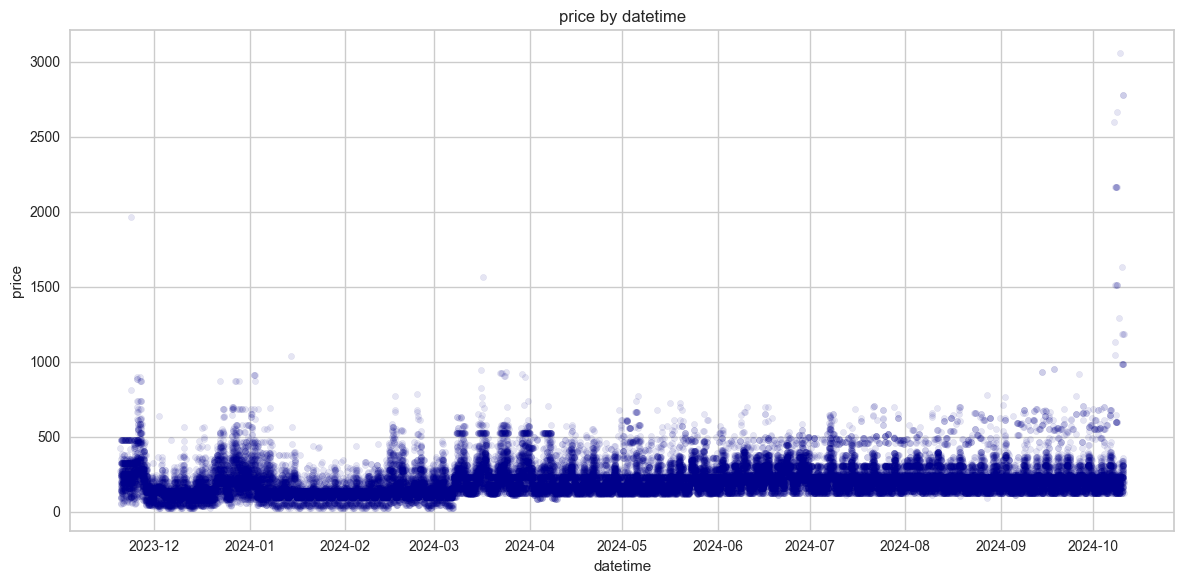

In [26]:
print("Creating first plot: Price vs. Date")
fig0, ax0 = plt.subplots(figsize=(12,6))
df.plot.scatter(x='deptDateTime', y='price', c='DarkBlue', ax=ax0, alpha=0.1)
ax0.set(xlabel='datetime', ylabel='price', title='price by datetime')
#df.plot.scatter(x='deptDateTime', y='price', c='DarkBlue')
plt.tight_layout()
#plot0_filename = 'output/01_price-by-date_scatter.png'
plt.show()

Why are the October 2024 prices so high? Let's just remove October 2024, maybe that's too far out

In [27]:
# Create mask
mask = (df['deptDateTime'].dt.month == 10) & (df['deptDateTime'].dt.year == 2024) & (df['deptDateTime'].dt.day > 5)
# Use the mask to drop the rows
df = df[~mask]

Creating first plot again: Price vs. Date


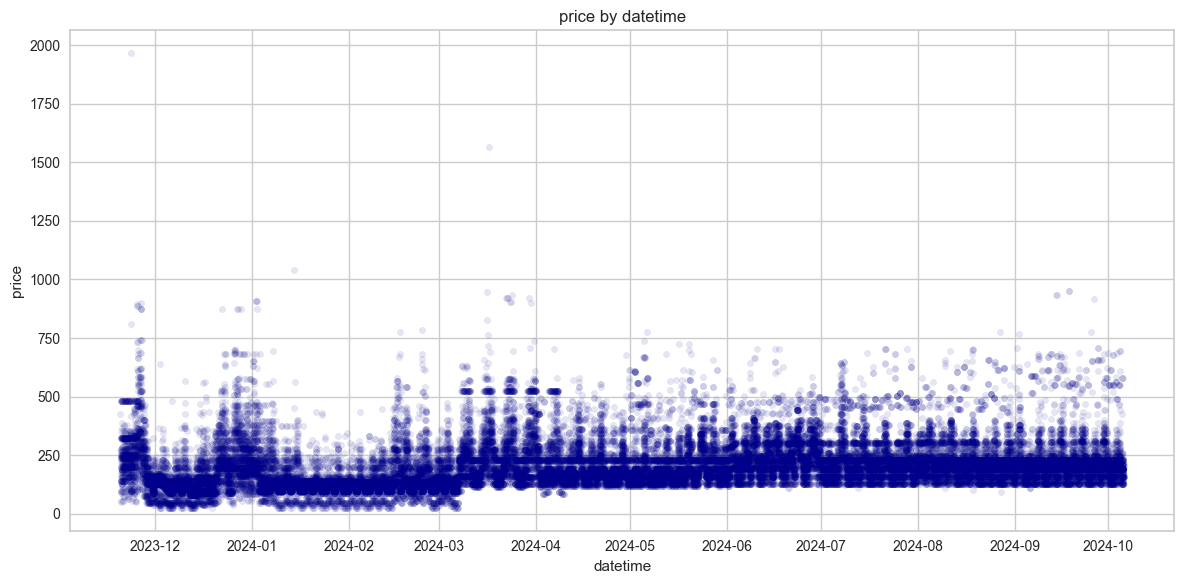

In [28]:
print("Creating first plot again: Price vs. Date")
fig0, ax0 = plt.subplots(figsize=(12,6))
df.plot.scatter(x='deptDateTime', y='price', c='DarkBlue', ax=ax0, alpha=0.1)
ax0.set(xlabel='datetime', ylabel='price', title='price by datetime')
#df.plot.scatter(x='deptDateTime', y='price', c='DarkBlue')
plt.tight_layout()
#plot0_filename = 'output/01_price-by-date_scatter.png'
plt.show()

#### Let's now explore the data by charting avg. price vs. day of week

In [29]:
# Find mean price by dayOfWeek
df_dow = df.groupby('deptDayOfWeek')
mean_dow = df_dow.mean()
mean_dow = mean_dow.reset_index()

In [30]:
mean_dow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   deptDayOfWeek   7 non-null      int64  
 1   price           7 non-null      float64
 2   duration        7 non-null      float64
 3   numConex        7 non-null      float64
 4   arrvDayOfWeek   7 non-null      float64
 5   deptMonth       7 non-null      float64
 6   deptDayOfYear   7 non-null      float64
 7   deptHour        7 non-null      float64
 8   deptDayOfMonth  7 non-null      float64
dtypes: float64(8), int64(1)
memory usage: 632.0 bytes


In [31]:
# Monday=0, Sunday=6
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html
mean_dow.head(10)

,deptDayOfWeek,price,duration,numConex,arrvDayOfWeek,deptMonth,deptDayOfYear,deptHour,deptDayOfMonth
0,0,212.924779,256.592184,1.438386,0.061456,5.876458,163.674441,12.587457,15.497321
1,1,176.138508,259.597088,1.465580,1.055389,5.916759,165.218547,12.295616,15.826555
2,2,178.614870,261.592020,1.461126,2.057089,5.948589,166.533512,12.287809,16.180098
3,3,204.576618,271.651090,1.472009,3.066959,5.970989,166.892426,12.043751,15.831425
4,4,218.672087,265.117297,1.451623,4.065391,6.018504,168.000941,12.405363,15.534107
5,5,202.238069,257.950473,1.445426,5.055521,6.032808,168.764353,12.270505,15.851262
6,6,256.776815,285.350566,1.484761,5.519866,5.969363,167.397958,12.034147,16.410882


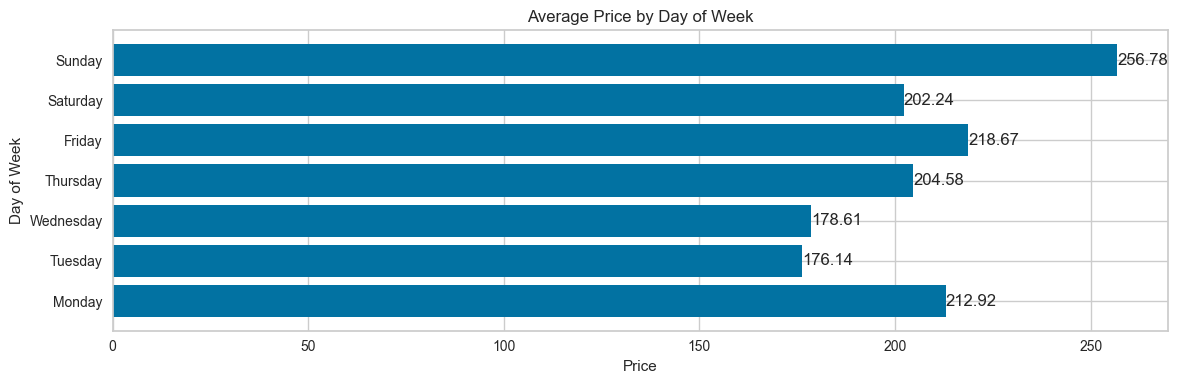

In [32]:
fig1, ax1 = plt.subplots(figsize=(12,4))
mean_dow_tmp = mean_dow.drop(columns=['duration', 'numConex', 'arrvDayOfWeek', 'deptMonth'])
daysOfWeek = ['','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#mean_dow_tmp['price'].plot.barh(x='price', y='deptDayOfWeek')
bars = ax1.barh(mean_dow_tmp['deptDayOfWeek'], mean_dow_tmp['price'])
ax1.set(ylabel='Day of Week', xlabel='Price', title='Average Price by Day of Week')
ax1.set_yticklabels(daysOfWeek)
ax1.bar_label(bars, fmt='{:,.2f}') # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar_label.html
plt.tight_layout()
plt.show()

#### Let's now explore the data by charting avg. price vs. month

In [33]:
# Find mean price by month
df_mon = df.groupby('deptMonth')
mean_mon = df_mon.mean()
mean_mon = mean_mon.reset_index()
mean_mon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   deptMonth       12 non-null     int64  
 1   price           12 non-null     float64
 2   duration        12 non-null     float64
 3   numConex        12 non-null     float64
 4   deptDayOfWeek   12 non-null     float64
 5   arrvDayOfWeek   12 non-null     float64
 6   deptDayOfYear   12 non-null     float64
 7   deptHour        12 non-null     float64
 8   deptDayOfMonth  12 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 992.0 bytes


In [34]:
# 1=January, 2=February, etc.
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html
mean_mon.head(12)

,deptMonth,price,duration,numConex,deptDayOfWeek,arrvDayOfWeek,deptDayOfYear,deptHour,deptDayOfMonth
0,1,143.680895,257.714219,1.379647,2.813662,2.810409,15.969331,11.876162,15.969331
1,2,151.246061,240.919742,1.345306,3.006440,2.992569,46.028982,12.144166,15.028982
2,3,233.228226,237.239176,1.295439,3.192406,3.158138,76.004399,12.523038,16.004399
3,4,207.390678,268.108732,1.510945,2.841713,2.810440,106.453933,12.422661,15.453933
4,5,216.352733,269.085156,1.544343,3.007763,2.984945,136.999530,12.330981,15.999530
5,6,249.855082,279.130329,1.543605,3.186289,3.151405,167.521318,12.349079,15.521318
6,7,230.331498,270.625000,1.536985,2.802903,2.793305,198.002107,12.267088,16.002107
7,8,227.684463,271.605461,1.534369,3.107580,3.100282,228.967750,12.271422,15.967750
8,9,226.023595,260.462895,1.518246,3.008327,2.998530,259.502327,12.264266,15.502327
9,10,215.398234,269.205499,1.538350,2.985528,3.037627,276.985528,12.247467,2.985528


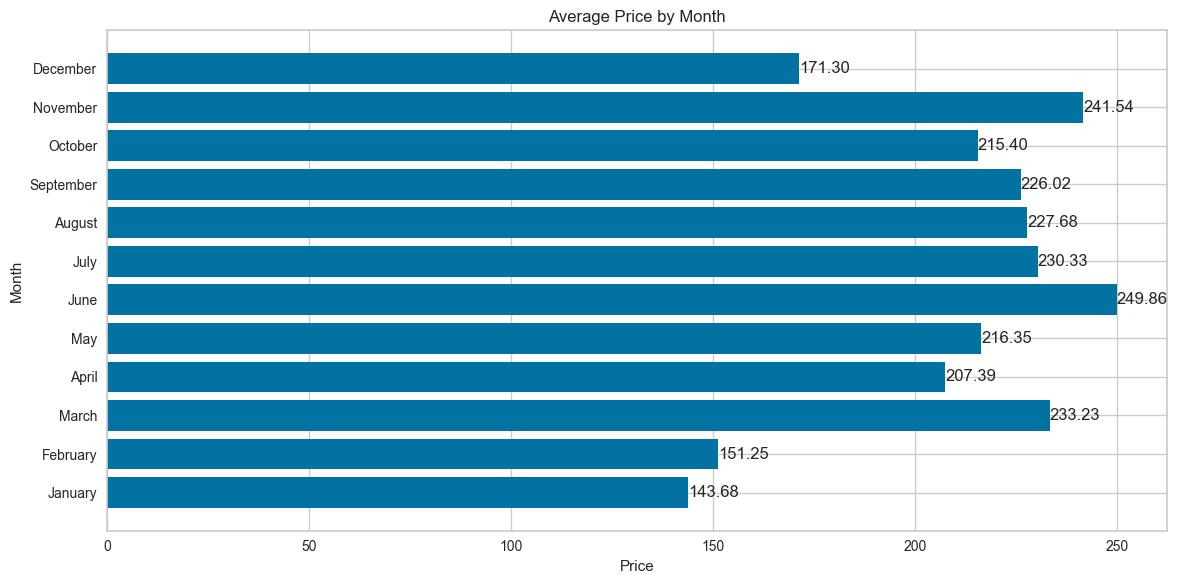

In [35]:
fig2, ax2 = plt.subplots(figsize=(12,6))
mean_mon_tmp = mean_mon.drop(columns=['duration', 'numConex', 'deptDayOfWeek', 'arrvDayOfWeek'])
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
bars = ax2.barh(mean_mon_tmp['deptMonth'], mean_mon_tmp['price'])
ax2.set(ylabel='Month', xlabel='Price', title='Average Price by Month')
ax2.set_yticks(mean_mon_tmp['deptMonth'])
ax2.set_yticklabels(months)
ax2.bar_label(bars, fmt='{:,.2f}')
plt.tight_layout()
plt.show()

#### Let's now explore the data by charting average flight price vs. day of year

In [36]:
df_doy = df.groupby('deptDayOfYear')['price'].mean()
df_doy = df_doy.reset_index()
df_doy.head(10)



,deptDayOfYear,price
0,1,259.394786
1,2,267.975071
2,3,186.024357
3,4,162.957786
4,5,162.622071
5,6,172.204143
6,7,199.856857
7,8,147.448143
8,9,116.072230
9,10,115.745522


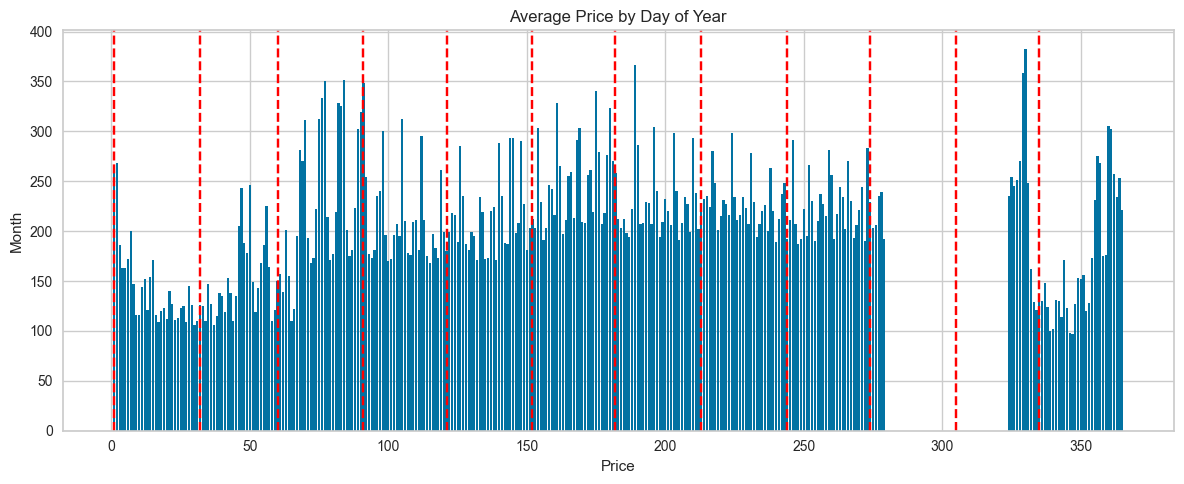

In [37]:
fig3, ax3 = plt.subplots(figsize=(12,5))
bars = ax3.bar(df_doy['deptDayOfYear'], df_doy['price'])
ax3.set(ylabel='Month', xlabel='Price', title='Average Price by Day of Year')

# Add vertical lines for the months ( https://stackoverflow.com/questions/71419004/how-to-plot-vertical-lines-at-specific-dates-in-matplotlib )
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
for day in month_days:
   ax3.axvline(x=day, color='red', linestyle='--')

plt.tight_layout()
plt.show()

I'd like to create the same chart above, but in calendar heatmap form beacuse those look really nice!

https://medium.com/analytics-vidhya/calendar-heatmaps-a-perfect-way-to-display-your-time-series-quantitative-data-ad36bf81a3ed

https://calplot.readthedocs.io/en/latest/index.html

https://matplotlib.org/stable/users/explain/colors/colormaps.html

Let's begin!

In [39]:
df_cal = df.copy()
df_cal.head()

,destName,orgName,deptDateTime,arrvDateTime,price,marktName,flightNum,duration,numConex,url,deptDayOfWeek,arrvDayOfWeek,deptMonth,deptDate,arrvDate,deptDayOfYear,deptHour,deptDayOfMonth
0,Cincinnati,Denver,2023-11-20 20:46:00,2023-11-21 01:29:00,55.29,Frontier Airlines,F94128,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,1,11,2023-11-20,2023-11-21,324,20,20
1,Cincinnati,Denver,2023-11-20 09:40:00,2023-11-20 14:15:00,95.16,Allegiant Air,G4406,155.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20
2,Cincinnati,Denver,2023-11-20 05:55:00,2023-11-20 10:38:00,96.45,Frontier Airlines,F93286,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,5,20
3,Cincinnati,Denver,2023-11-20 17:50:00,2023-11-20 22:37:00,138.59,United Airlines,UA1830,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,17,20
4,Cincinnati,Denver,2023-11-20 09:42:00,2023-11-20 14:29:00,186.79,United Airlines,UA1978,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20


In [40]:
df_cal = df_cal[['deptDate', 'price']]
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   deptDate  44367 non-null  object 
 1   price     44367 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


In [41]:
df_cal['deptDate'] = pd.to_datetime(df_cal['deptDate'])

In [42]:
df_cal = df_cal.groupby('deptDate').mean()
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2023-11-20 to 2024-10-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   321 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


In [43]:
df_cal.head(10)

,price
deptDate,
2023-11-20,234.874857
2023-11-21,253.916000
2023-11-22,245.188571
2023-11-23,251.482571
2023-11-24,270.612571
2023-11-25,358.938071
2023-11-26,382.092929
2023-11-27,247.859071
2023-11-28,162.324714


In [44]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2023-11-20 to 2024-10-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   321 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


In [45]:
import calplot
print(type(df_cal.index))
# The index should be a DatetimeIndex for calplot

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


(<Figure size 1250x340 with 3 Axes>,
 array([<Axes: ylabel='2023'>, <Axes: ylabel='2024'>], dtype=object))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


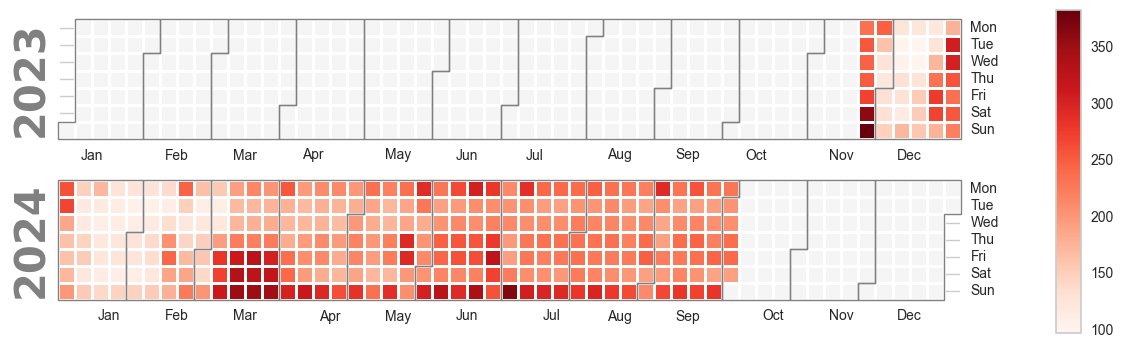

In [71]:
calplot.calplot(df_cal['price'], cmap='Reds', colorbar=True, textformat=None) # textformat='{:.0f}')

#### Let's now explore the data by charting average flight price vs. hour of day

In [47]:
# Find mean price by hour
df_hr = df.groupby('deptHour')
mean_hr = df_hr.mean()
mean_hr = mean_hr.reset_index()
mean_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   deptHour        21 non-null     int64  
 1   price           21 non-null     float64
 2   duration        21 non-null     float64
 3   numConex        21 non-null     float64
 4   deptDayOfWeek   21 non-null     float64
 5   arrvDayOfWeek   21 non-null     float64
 6   deptMonth       21 non-null     float64
 7   deptDayOfYear   21 non-null     float64
 8   deptDayOfMonth  21 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 1.6 KB


In [48]:
mean_hr.head(24)

,deptHour,price,duration,numConex,deptDayOfWeek,arrvDayOfWeek,deptMonth,deptDayOfYear,deptDayOfMonth
0,0,198.537173,225.138520,1.030361,2.963947,2.963947,5.851992,163.481973,16.119545
1,1,88.750000,225.000000,1.000000,4.000000,4.000000,2.333333,54.000000,13.333333
2,5,190.912104,253.836174,1.834087,3.074435,3.072696,6.055304,169.376348,15.772174
3,6,187.704626,247.673737,1.466001,3.019339,3.017779,5.901747,164.856519,15.913911
4,7,209.693897,266.735380,1.401939,3.116963,3.113409,5.906947,165.029402,15.933764
5,8,209.051216,243.268307,1.458939,3.116513,3.108509,6.137267,171.941891,15.847317
6,9,216.392712,235.181239,1.230051,3.070883,3.043718,5.553905,154.486418,16.122666
7,10,227.043197,330.741685,1.941685,2.945572,2.958963,5.902376,164.593952,15.606911
8,11,242.124816,288.542832,1.291084,3.107955,3.098776,6.034965,168.941871,15.956731
9,12,220.527629,285.922811,1.668051,2.913811,2.908619,5.776393,160.902042,15.757009


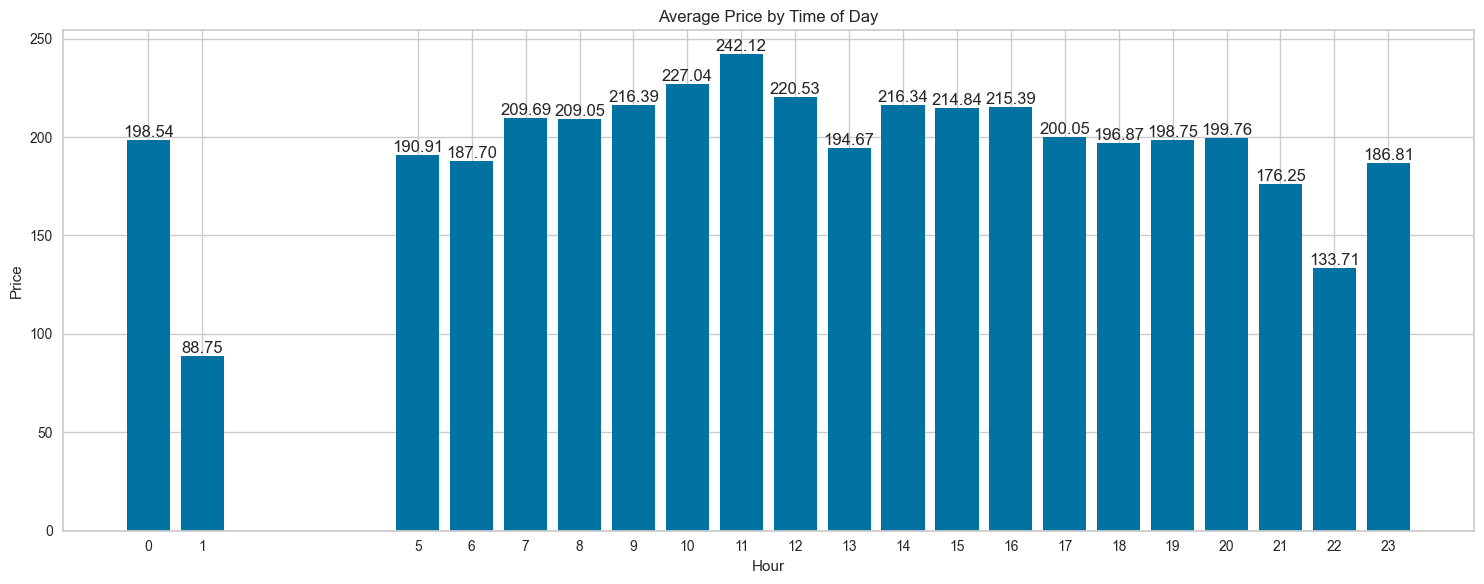

In [49]:
fig4, ax4 = plt.subplots(figsize=(15,6))
mean_hr_tmp = mean_hr.drop(columns=['duration', 'numConex', 'deptDayOfWeek', 'arrvDayOfWeek', 'deptMonth', 'deptDayOfYear'])
#months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
bars = ax4.bar(mean_hr_tmp['deptHour'], mean_hr_tmp['price'])
ax4.set(xlabel='Hour', ylabel='Price', title='Average Price by Time of Day')
ax4.set_xticks(mean_hr_tmp['deptHour'])
#ax4.set_yticklabels(months)
ax4.bar_label(bars, fmt='{:,.2f}')
plt.tight_layout()
plt.show()

#### Now let's start with the machine learning models

Let's see, what features and what targets do we want...

From a few articles:

* https://datascience.stackexchange.com/questions/2368/machine-learning-features-engineering-from-date-time-data
* https://datascience.stackexchange.com/questions/112357/feature-engineering-for-datetime-column

It seems like popular features are dayOfWeek, dayOfMonth, dayOfYear, hour, and month. This is what we will use.

##### Features

* deptDayOfWeek
* deptDayOfMonth
* deptDayOfYear
* deptHour
* deptMonth
* marktName
* orgName
* destName

##### Targets

* price


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   destName        44367 non-null  object        
 1   orgName         44367 non-null  object        
 2   deptDateTime    44367 non-null  datetime64[ns]
 3   arrvDateTime    44367 non-null  datetime64[ns]
 4   price           44367 non-null  float64       
 5   marktName       44367 non-null  object        
 6   flightNum       44367 non-null  object        
 7   duration        44367 non-null  float64       
 8   numConex        44367 non-null  int64         
 9   url             44367 non-null  object        
 10  deptDayOfWeek   44367 non-null  int64         
 11  arrvDayOfWeek   44367 non-null  int64         
 12  deptMonth       44367 non-null  int64         
 13  deptDate        44367 non-null  object        
 14  arrvDate        44367 non-null  object        
 15  de

In [51]:
df.head(15)

,destName,orgName,deptDateTime,arrvDateTime,price,marktName,flightNum,duration,numConex,url,deptDayOfWeek,arrvDayOfWeek,deptMonth,deptDate,arrvDate,deptDayOfYear,deptHour,deptDayOfMonth
0,Cincinnati,Denver,2023-11-20 20:46:00,2023-11-21 01:29:00,55.29,Frontier Airlines,F94128,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,1,11,2023-11-20,2023-11-21,324,20,20
1,Cincinnati,Denver,2023-11-20 09:40:00,2023-11-20 14:15:00,95.16,Allegiant Air,G4406,155.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20
2,Cincinnati,Denver,2023-11-20 05:55:00,2023-11-20 10:38:00,96.45,Frontier Airlines,F93286,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,5,20
3,Cincinnati,Denver,2023-11-20 17:50:00,2023-11-20 22:37:00,138.59,United Airlines,UA1830,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,17,20
4,Cincinnati,Denver,2023-11-20 09:42:00,2023-11-20 14:29:00,186.79,United Airlines,UA1978,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20
5,Cincinnati,Denver,2023-11-20 05:00:00,2023-11-20 12:27:00,141.53,American Airlines,AA2612,327.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,5,20
6,Cincinnati,Denver,2023-11-20 07:25:00,2023-11-20 15:54:00,141.53,American Airlines,AA852,389.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,7,20
7,Cincinnati,Denver,2023-11-20 06:00:00,2023-11-20 15:54:00,141.53,American Airlines,AA1067,474.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,6,20
8,Cincinnati,Denver,2023-11-20 16:36:00,2023-11-20 23:59:00,192.26,American Airlines,AA1832,323.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,16,20
9,Cincinnati,Denver,2023-11-20 23:59:00,2023-11-21 12:29:00,195.61,Spirit Airlines,NK1320,630.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,1,11,2023-11-20,2023-11-21,324,23,20


In [52]:
features = df[['deptDayOfWeek', 'deptDayOfMonth', 'deptDayOfYear', 'deptHour', 'deptMonth', 'marktName', 'orgName', 'destName']]
print(features)

       deptDayOfWeek  deptDayOfMonth  deptDayOfYear  deptHour  deptMonth  \
0                  0              20            324        20         11   
1                  0              20            324         9         11   
2                  0              20            324         5         11   
3                  0              20            324        17         11   
4                  0              20            324         9         11   
...              ...             ...            ...       ...        ...   
44912              5               5            279         7         10   
44913              5               5            279        12         10   
44914              5               5            279        12         10   
44915              5               5            279        20         10   
44916              5               5            279        16         10   

               marktName     orgName    destName  
0      Frontier Airlines      Denver

In [53]:
targets = df[['price']]
print(targets)

        price
0       55.29
1       95.16
2       96.45
3      138.59
4      186.79
...       ...
44912  192.20
44913  192.20
44914  192.20
44915  192.20
44916  192.20

[44367 rows x 1 columns]


<Axes: >

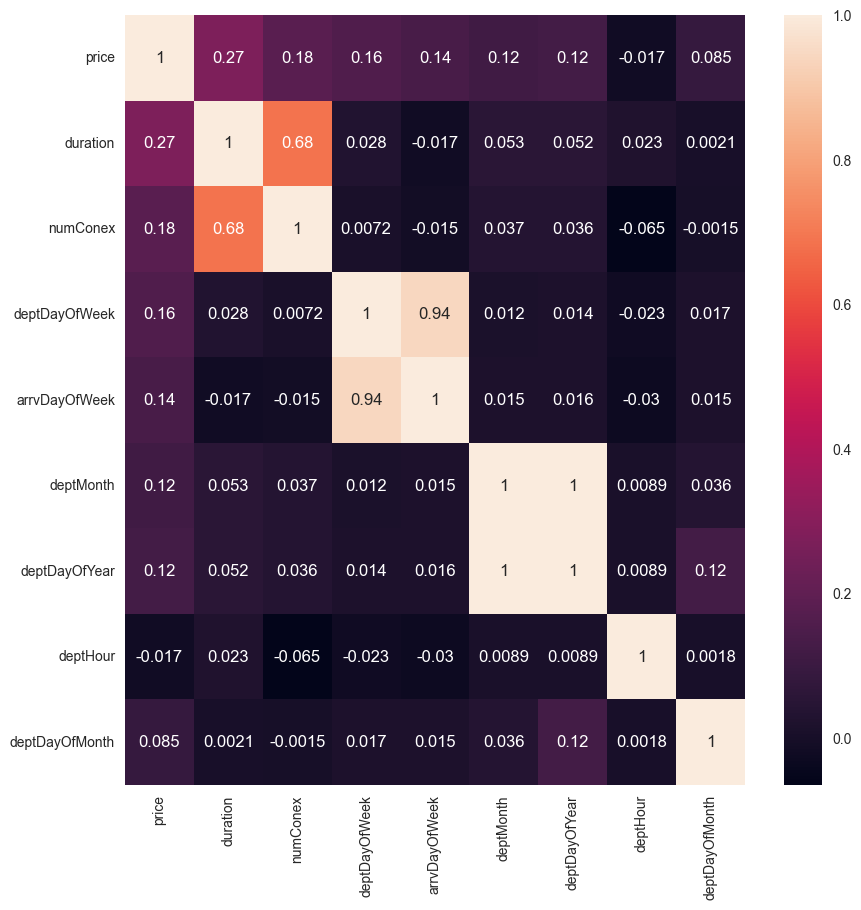

In [54]:
#plot the correlations between features and targets
f = plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

All of the above heatmap definitely makes sense:

* duration strongly positively correlated to numConex
* arrival day strongly corresponds with departure day 

Now I need to create some dummy variables. 

I had some thought too about whether month, dayOfWeek, etc. were numerical or categorical....

Monday=0, Tuesday=1, etc... but Tuesday is not bigger than Monday. 

https://www.reddit.com/r/learnpython/comments/chunas/correlation_with_day_of_week/

https://mikulskibartosz.name/time-in-machine-learning  

This might be a loooooooot of dummy variables...

In [55]:
# Get the dummies and store it in a variable
#dummies = pd.get_dummies(features['marktName'])
features_dum = pd.get_dummies(features, columns=['marktName', 'orgName', 'destName'])
features_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   deptDayOfWeek                44367 non-null  int64
 1   deptDayOfMonth               44367 non-null  int64
 2   deptDayOfYear                44367 non-null  int64
 3   deptHour                     44367 non-null  int64
 4   deptMonth                    44367 non-null  int64
 5   marktName_Aeromexico         44367 non-null  uint8
 6   marktName_Air Canada         44367 non-null  uint8
 7   marktName_Air Transat        44367 non-null  uint8
 8   marktName_Alaska Airlines    44367 non-null  uint8
 9   marktName_Allegiant Air      44367 non-null  uint8
 10  marktName_American Airlines  44367 non-null  uint8
 11  marktName_Breeze Airways     44367 non-null  uint8
 12  marktName_Canada Jetlines    44367 non-null  uint8
 13  marktName_Flair Airlines     44367 non-null  u

In [56]:
#split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features_dum, targets, test_size=0.22, random_state=23)
print("x_train")
print(x_train)
print("x_test")
print(x_test)
print("y_train")
print(y_train)
print("y_test")
print(y_test)
#default size is 25% test size

x_train
       deptDayOfWeek  deptDayOfMonth  deptDayOfYear  deptHour  deptMonth  \
34054              0              17            169        15          6   
2418               3              18            200        14          7   
11475              3               9            130         7          5   
42628              6              18             49         9          2   
27043              2              17            108        17          4   
...              ...             ...            ...       ...        ...   
9836               0              27            331        15         11   
11322              2              24            115        14          4   
26886              0               1             92        12          4   
9338               3              29            242         7          8   
42105              2              27            361         9         12   

       marktName_Aeromexico  marktName_Air Canada  marktName_Air Transat  \
340

In [57]:
#use at least one ML model to fit to the training data
#create the model first, then fit it to training data
lr_model = LinearRegression()
lr_model = lr_model.fit(x_train, y_train)

In [58]:
# https://realpython.com/linear-regression-in-python/
y_predictions = lr_model.predict(x_test)

In [59]:
# Calculate mean squared error
mse = mean_squared_error(y_test, y_predictions)
print("Mean Squared Error:", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_predictions)
print("R-squared:", r2)

Mean Squared Error: 6521.198511653704
R-squared: 0.34745288803488017


So after creating our features_dum and targets for our test LinearRegression model, we want to move onto pycaret.

Before we do that though, I'm going to concatenate our features_dum and targets (well, target) into one dataframe, df_dum

In [60]:
df_dum = pd.concat([features_dum, targets], axis='columns')

In [61]:
df_dum.columns

Index(['deptDayOfWeek', 'deptDayOfMonth', 'deptDayOfYear', 'deptHour',
       'deptMonth', 'marktName_Aeromexico', 'marktName_Air Canada',
       'marktName_Air Transat', 'marktName_Alaska Airlines',
       'marktName_Allegiant Air', 'marktName_American Airlines',
       'marktName_Breeze Airways', 'marktName_Canada Jetlines',
       'marktName_Flair Airlines', 'marktName_Frontier Airlines',
       'marktName_Key Lime Air', 'marktName_LATAM', 'marktName_Lynx Air',
       'marktName_Porter Airlines', 'marktName_Silver Airways',
       'marktName_Spirit Airlines', 'marktName_Sun Country',
       'marktName_United Airlines', 'marktName_Volaris', 'marktName_WestJet',
       'orgName_Chicago', 'orgName_Cincinnati', 'orgName_Denver',
       'orgName_Los Angeles', 'orgName_Miami', 'orgName_New York',
       'orgName_Orlando', 'orgName_San Francisco', 'destName_Chicago',
       'destName_Cincinnati', 'destName_Denver', 'destName_Los Angeles',
       'destName_Miami', 'destName_New York', 'dest

In [62]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   deptDayOfWeek                44367 non-null  int64  
 1   deptDayOfMonth               44367 non-null  int64  
 2   deptDayOfYear                44367 non-null  int64  
 3   deptHour                     44367 non-null  int64  
 4   deptMonth                    44367 non-null  int64  
 5   marktName_Aeromexico         44367 non-null  uint8  
 6   marktName_Air Canada         44367 non-null  uint8  
 7   marktName_Air Transat        44367 non-null  uint8  
 8   marktName_Alaska Airlines    44367 non-null  uint8  
 9   marktName_Allegiant Air      44367 non-null  uint8  
 10  marktName_American Airlines  44367 non-null  uint8  
 11  marktName_Breeze Airways     44367 non-null  uint8  
 12  marktName_Canada Jetlines    44367 non-null  uint8  
 13  marktName_Flair 

In [63]:
df_dum.head(10)

,deptDayOfWeek,deptDayOfMonth,deptDayOfYear,deptHour,deptMonth,marktName_Aeromexico,marktName_Air Canada,marktName_Air Transat,marktName_Alaska Airlines,marktName_Allegiant Air,...,orgName_San Francisco,destName_Chicago,destName_Cincinnati,destName_Denver,destName_Los Angeles,destName_Miami,destName_New York,destName_Orlando,destName_San Francisco,price
0,0,20,324,20,11,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,55.29
1,0,20,324,9,11,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,95.16
2,0,20,324,5,11,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,96.45
3,0,20,324,17,11,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,138.59
4,0,20,324,9,11,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,186.79
5,0,20,324,5,11,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,141.53
6,0,20,324,7,11,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,141.53
7,0,20,324,6,11,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,141.53
8,0,20,324,16,11,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,192.26
9,0,20,324,23,11,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,195.61


#### Now I want to use pycarat to compare ml models

https://www.pycaret.org/tutorials/html/REG101.html

https://pycaret.readthedocs.io/en/latest/api/regression.html

I don't really understand the default 'fold' parameter of 10 but it seems to be related to computational power. I will stick with the default of 10. 

"Reducing the number of folds will improve the training time."

In [72]:
exp_reg101 = setup(data = df_dum, target = 'price', session_id=23)

,Description,Value
0,Session id,23
1,Target,price
2,Target type,Regression
3,Original data shape,"(44367, 42)"
4,Transformed data shape,"(44367, 42)"
5,Transformed train set shape,"(31056, 42)"
6,Transformed test set shape,"(13311, 42)"
7,Numeric features,41
8,Preprocess,True
9,Imputation type,simple


In [65]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,22.2483,1730.7426,41.4515,0.8297,0.1689,0.1096,3.9050
et,Extra Trees Regressor,21.9566,1798.4410,42.2105,0.8232,0.1724,0.1087,3.7980
lightgbm,Light Gradient Boosting Machine,32.0795,2472.7083,49.6769,0.7560,0.2094,0.1630,0.2530
dt,Decision Tree Regressor,25.6391,2921.5403,53.8201,0.7125,0.2159,0.1226,0.1180
gbr,Gradient Boosting Regressor,44.9768,4409.1124,66.3613,0.5648,0.2840,0.2358,1.0580
knn,K Neighbors Regressor,48.0628,5365.1148,73.2043,0.4706,0.3132,0.2535,0.2920
lr,Linear Regression,56.6982,6516.1759,80.6988,0.3561,0.3747,0.3214,0.5510
br,Bayesian Ridge,56.6945,6516.3571,80.7000,0.3560,0.3747,0.3214,0.0770
ridge,Ridge Regression,56.6957,6518.1803,80.7114,0.3559,0.3746,0.3216,0.0490
lasso,Lasso Regression,61.1210,7504.1230,86.5911,0.2591,0.3977,0.3546,0.0500


The pycaret Linear Regression results track with our former Linear Regression that we performed ourselves!

Looks like Random Forest is the best model according to Mean Squared Error, Root Mean Squared Error, and R^2 value.

Let's go with that.

In [66]:
model = create_model('rf')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,21.3389,1493.7431,38.6490,0.8414,0.1634,0.1058
1,22.4379,1686.9541,41.0725,0.8417,0.1687,0.1096
2,22.3571,1545.3638,39.3111,0.8458,0.1698,0.1091
3,22.4362,1505.7581,38.8041,0.8341,0.1701,0.1130
4,22.8891,1862.1858,43.1531,0.8142,0.1736,0.1096
5,21.4983,1544.1484,39.2957,0.8422,0.1684,0.1084
6,22.3448,2485.4013,49.8538,0.7754,0.1678,0.1066
7,23.2849,2078.0391,45.5855,0.8038,0.1731,0.1140
8,21.7072,1628.8257,40.3587,0.8366,0.1630,0.1075


In [67]:
evaluate_model(model)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [68]:
new_data = pd.DataFrame({'deptDayOfWeek': [0], 'deptDayOfMonth': [27], 'deptDayOfYear': ['2023-11-27'], 
                         'deptHour': [10], 'deptMonth': [11], 'marktName_Aeromexico': [0], 'marktName_Air Canada': [0], 
                         'marktName_Air Transat': [0], 'marktName_Alaska Airlines': [0], 'marktName_Allegiant Air': [0], 
                         'marktName_American Airlines': [0], 'marktName_Breeze Airways': [0], 'marktName_Canada Jetlines': [0], 
                         'marktName_Flair Airlines': [0], 'marktName_Frontier Airlines': [0], 'marktName_Key Lime Air': [0], 
                         'marktName_LATAM': [0], 'marktName_Lynx Air': [0], 'marktName_Porter Airlines': [0], 
                         'marktName_Silver Airways': [0], 'marktName_Spirit Airlines': [0], 'marktName_Sun Country': [0], 
                         'marktName_United Airlines': [1], 'marktName_Volaris': [0], 'marktName_WestJet': [0], 
                         'orgName_Chicago': [0], 'orgName_Cincinnati': [0], 'orgName_Denver': [1], 'orgName_Los Angeles': [0], 
                         'orgName_Miami': [0], 'orgName_New York': [0], 'orgName_Orlando': [0], 'orgName_San Francisco': [0], 
                         'destName_Chicago': [0], 'destName_Cincinnati': [1], 'destName_Denver': [0], 'destName_Los Angeles': [0], 
                         'destName_Miami': [0], 'destName_New York': [0], 'destName_Orlando': [0], 'destName_San Francisco': [0]})

new_data['deptDayOfYear'] = pd.to_datetime(new_data['deptDayOfYear'])
new_data['deptDayOfYear'] = new_data['deptDayOfYear'].dt.dayofyear

predictions = predict_model(model, data = new_data)


In [69]:
print(predictions['prediction_label'])

0    274.805603
Name: prediction_label, dtype: float64


In [70]:
conn.commit()
conn.close()